# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
# Read CSV file
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
# URL of the file to download
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

# Send a GET request to download the file
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Save the file locally
    with open("image_predictions.tsv", "wb") as file:
        file.write(response.content)
    print("File downloaded successfully.")
else:
    print("Error downloading the file.")


File downloaded successfully.


In [4]:
# Read CSV file
image_predictions = pd.read_csv('image-predictions.tsv', sep ='\t')
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [5]:
# URL of the file to download
url = 'https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt'


# Send a GET request to download the file
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Save the file locally
    with open('tweet-json.txt', "wb") as file:
        file.write(response.content)
    print("File downloaded successfully.")
else:
    print("Error downloading the file.")

File downloaded successfully.


In [6]:
df_list = []
with open('tweet-json.txt') as file:
    raw_line = file.readlines()
    for line in raw_line:
        raw_obj = json.loads(line)
        tweet_id = raw_obj['id']
        retweet_count = raw_obj['retweet_count']
        favorite_count = raw_obj['favorite_count']
        # Append to list of dictionaries
        df_list.append({'tweet_id': tweet_id,
                        'retweet_count': retweet_count,
                        'favorite_count': favorite_count})
df_tweet = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])
df_tweet

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [7]:
#Get info of twitter_archive
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [8]:
#Check tweet_id duplicate of twitter_archive
sum(twitter_archive.tweet_id.duplicated())

0

In [9]:
#Get the value of column 'source' of twitter_archive
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [10]:
#Get the value of column 'text' of twitter_archive
twitter_archive.text.value_counts().head(10)

Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq                                   1
These two dogs are Bo &amp; Smittens. Smittens is trying out a new deodorant and wanted Bo to smell it. 10/10 true pals https://t.co/4pw1QQ6udh            1
Yea I can't handle the cuteness anymore. Curls for days. 12/10 for all https://t.co/sAI6gCGZYX                                                             1
"Can you behave? You're ruining my wedding day"\nDOG: idgaf this flashlight tastes good as hell\n\n10/10 https://t.co/GlFZPzqcEU                           1
This is Vincent. He's suave as h*ck. Will be your copilot this evening. Claims he doesn't need to look at the directions. 12/10 https://t.co/u51tzXSVi3    1
This is Bear. Don't worry, he's not a real bear tho. Contains unreal amounts of squish. 11/10 heteroskedastic af https://t.co/coi4l1T2Sm                   1
Meet Patrick. He's an exotic pup. Jumps great distances fo

In [11]:
#Check for non-proper dog names (does not start with A-Z)
twitter_archive[twitter_archive['name'].str.contains('^[a-z]')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139...,14,10,such,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. This is quite clearly a smo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Guys, we only rate dogs. This is quite clearly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/855459453...,12,10,quite,None,None,None,None
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",There's going to be a dog terminal at JFK Airp...,NaN,NaN,NaN,http://us.blastingnews.com/news/2017/02/jfk-an...,10,10,not,None,None,None,None
369,828650029636317184,NaN,NaN,2017-02-06 17:02:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Occasionally, we're sent fantastic stories. Th...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/828650029...,14,10,one,None,None,None,None
542,806219024703037440,NaN,NaN,2016-12-06 19:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Please stop sending in non-...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/806219024...,11,10,incredibly,None,None,None,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
682,788552643979468800,NaN,NaN,2016-10-19 01:29:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to mad pupper. You kn...,7.363926e+17,4.196984e+09,2016-05-28 03:04:00 +0000,"https://vine.co/v/iEggaEOiLO3,https://vine.co/...",13,10,mad,None,None,pupper,None


In [12]:
#Info of image_predictions
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
##Check tweet_id duplicate of image_predictions
sum(image_predictions.tweet_id.duplicated())

0

In [14]:
##Check jpg_url duplicate of image_predictions
sum(image_predictions.jpg_url.duplicated())

66

In [15]:
#Get name of breed of dog in p1
image_predictions.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
German_shepherd               20
Siberian_husky                20
Staffordshire_bullterrier     20
Cardigan                      19
web_site                      19
beagle                        18
Maltese_dog                   18
Eskimo_dog                    18
Shetland_sheepdog             18
teddy                         18
Rottweiler                    17
Lakeland_terrier              17
Shih-Tzu                      17
Italian_greyhound             16
kuvasz                        16
          

In [16]:
#Info of df_tweet
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


### Through observation and some tests above, there are several issues:

### Quality issues
1. twitter-archive-enhanced.csv: Retweets need to be removed <br>

2. twitter-archive-enhanced.csv: datatype of time is incorrect <br>

3. twitter-archive-enhanced.csv, column "source" have url and name are not necessary <br>

4. twitter-archive-enhanced.csv, many record have name not a proper name (start with a lowercase character) <br>

5. Id is having data type as int instead of String <br>

6. In file image_predictions.tsv, duplicate value in the jpg_url <br>

7. Many reprediction isn't a breed of dog (p1_dog,p2_dog,p3_dog are FALSE) <br>

8. Name of breed of dog are inconsistent (start capitalize letter/lowercase)

### Tidiness issues
9. In twitter_archive.tsv : doggo, floofer, pupper, puppo is the way to categorize dogs so grouped into 1 column. <br>
10. There are many columns about dog breed predictions, so it is recommended to combine the columns into one column.
11. Merge all tables into one master dataset

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [17]:
# Make copies of original pieces of data

twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
twitter_tweet_clean = df_tweet.copy()


### Issue #1:

- twitter-archive-enhanced.csv: Retweets need to be removed

#### Define:

- Remove rows that have value in retweeted_status_id, retweeted_status_user_id, or retweeted_status_timestamp.
- Remove rows with a text field that begins with 'RT @'.

#### Code

In [18]:
#Remove rows that have value in retweeted_status_id, retweeted_status_user_id, or retweeted_status_timestamp.
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull() 
                                              & twitter_archive_clean['retweeted_status_user_id'].isnull()
                                              & twitter_archive_clean['retweeted_status_timestamp'].isnull()]

In [19]:
#Remove rows with a text field that begins with 'RT @'.
twitter_archive_clean = twitter_archive_clean[~twitter_archive_clean['text'].str.startswith('RT @')]

In [20]:
twitter_archive_clean.reset_index(drop=True, inplace=True)

#### Test

In [21]:
#Check number of values in retweeted_status_id, retweeted_status_user_id, or retweeted_status_timestamp.
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

### Issue #2:

- twitter-archive-enhanced.csv: datatype of time is incorrect

#### Define

- Remove the '+0000' in last string
- Convert the timestamp

#### Code

In [22]:
#Remove the '+0000' in last string
twitter_archive_clean.timestamp = twitter_archive_clean.timestamp.str[:-6]

#Convert the timestamp
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive_clean.timestamp)

#### Test

In [23]:
#Check datatype of timestamp
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: datetime64[ns](1), flo

### Issue #3:

- twitter-archive-enhanced.csv, column "source" have url and name are not necessary

#### Define

- Replace data, only display name of source

#### Code

In [24]:
#Replace data, display name of source
twitter_archive_clean.source = twitter_archive_clean.source.replace({'<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>':'TweetDeck',
                                                                     '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>':'Vine - Make a Scene',
                                                                      '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>':'Twitter for iPhone',
                                                                     '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'Twitter Web Client'})


#### Test

In [25]:
#Check value of source
twitter_archive_clean.source.value_counts()

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

### Issue #4:

- twitter-archive-enhanced.csv, many record have name not a proper name (start with a lowercase character) 

#### Define

- Replace name start with a lowercase character to 'Unknown'

#### Code

In [26]:
mask = twitter_archive_clean.name.str.contains('^[a-z]', regex = True)

In [27]:
# Replace name start with a lowercase character to 'Unknown'
twitter_archive_clean.loc[mask,'name'] = 'Unknown'

#### Test

In [28]:
twitter_archive_clean[twitter_archive_clean['name'].str.contains('^[a-z]')].shape[0]

0

### Issue #5:

- Id is having data type as int instead of String

#### Define

Convert data type of column: tweet_id, in_reply_to_status_id, in_reply_to_user_id from int to string


#### Code

In [29]:
#Convert data type of column: tweet_id, in_reply_to_status_id, in_reply_to_user_id from int to string
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype(str)
twitter_archive_clean.in_reply_to_status_id = twitter_archive_clean.in_reply_to_status_id.astype(str)
twitter_archive_clean.in_reply_to_user_id = twitter_archive_clean.in_reply_to_user_id.astype(str)
image_predictions_clean.tweet_id = image_predictions_clean.tweet_id.astype(str)
twitter_tweet_clean.tweet_id = twitter_tweet_clean.tweet_id.astype(str)

#### Test

In [30]:
#Check data type of column: tweet_id, in_reply_to_status_id, in_reply_to_user_id
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 17 columns):
tweet_id                      2175 non-null object
in_reply_to_status_id         2175 non-null object
in_reply_to_user_id           2175 non-null object
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: datetime64[ns](1), 

### Issue #6:

- In file image_predictions.tsv, duplicate value in the jpg_url

#### Define

- Remove jpg_url duplication records

#### Code

In [31]:
#Remove jpg_url duplication records
image_predictions_clean = image_predictions_clean.drop_duplicates(subset=['jpg_url'], keep='first')

#### Test

In [32]:
#Check jpg_url duplication records
sum(image_predictions_clean.jpg_url.duplicated())

0

### Issue #7:

- Many reprediction isn't a breed of dog (p1_dog,p2_dog,p3_dog are FALSE)

#### Define

- Remove record which tweet_id have p1_dog and p2_dog and p3_dog are FALSE

#### Code

In [33]:
#Get tweet_id have p1_dog and p2_dog and p3_dog are FALSE
tweet_id_is_not_dog = image_predictions_clean.query('p1_dog == False and p3_dog == False and p2_dog == False').tweet_id

In [34]:
#Delete record have tweet_id get above
image_predictions_clean = image_predictions_clean[~image_predictions_clean['tweet_id'].isin(tweet_id_is_not_dog)]
twitter_archive_clean = twitter_archive_clean[~twitter_archive_clean['tweet_id'].isin(tweet_id_is_not_dog)]
twitter_tweet_clean = twitter_tweet_clean[~twitter_tweet_clean['tweet_id'].isin(tweet_id_is_not_dog)]


#### Test

In [35]:
#Count the number of records whose id exists in tweet_id_is_not_dog
image_predictions_clean[image_predictions_clean['tweet_id'].isin(tweet_id_is_not_dog)].shape[0]
+ twitter_archive_clean[twitter_archive_clean['tweet_id'].isin(tweet_id_is_not_dog)].shape[0]
+ twitter_archive_clean[twitter_archive_clean['tweet_id'].isin(tweet_id_is_not_dog)].shape[0]


0

### Issue #8:

Name of breed of dog are inconsistent (with capital letter, with lowercase)

#### Define

- Convert p1,p2,p3 into lowercase

#### Code

In [36]:
#Convert p1,p2,p3 into lowercase
image_predictions_clean.p1 = image_predictions_clean.p1.str.lower()
image_predictions_clean.p2 = image_predictions_clean.p2.str.lower()
image_predictions_clean.p3 = image_predictions_clean.p3.str.lower()

#### Test

In [37]:
image_predictions_clean[['p1','p2','p3']]

,p1,p2,p3
0,welsh_springer_spaniel,collie,shetland_sheepdog
1,redbone,miniature_pinscher,rhodesian_ridgeback
2,german_shepherd,malinois,bloodhound
3,rhodesian_ridgeback,redbone,miniature_pinscher
4,miniature_pinscher,rottweiler,doberman
5,bernese_mountain_dog,english_springer,greater_swiss_mountain_dog
7,chow,tibetan_mastiff,fur_coat
8,shopping_cart,shopping_basket,golden_retriever
9,miniature_poodle,komondor,soft-coated_wheaten_terrier
10,golden_retriever,tibetan_mastiff,labrador_retriever


### Issue #9:

- In twitter_archive.tsv : doggo, floofer, pupper, puppo is the way to categorize dogs so grouped into 1 column

#### Define

- Merge 4 columns doggo,floofer,pupper,puppo columns to a dog_categorize column

#### Code

In [38]:
#Merge 4 columns doggo,floofer,pupper,puppo columns to a dog_categorize column
twitter_archive_clean = pd.melt(twitter_archive_clean,
                          id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text','retweeted_status_id','retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name'],
                          var_name='dogs',
                          value_name='dog_categorize')
twitter_archive_clean = twitter_archive_clean.sort_values('dog_categorize').drop_duplicates(subset='tweet_id', keep='last')
twitter_archive_clean = twitter_archive_clean.drop('dogs', axis=1)

#### Test

In [39]:
#Check value in dog_categorize
twitter_archive_clean.dog_categorize.value_counts()

None       1569
pupper      198
doggo        66
puppo        24
floofer      10
Name: dog_categorize, dtype: int64

In [40]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1867 entries, 1799 to 5752
Data columns (total 14 columns):
tweet_id                      1867 non-null object
in_reply_to_status_id         1867 non-null object
in_reply_to_user_id           1867 non-null object
timestamp                     1867 non-null datetime64[ns]
source                        1867 non-null object
text                          1867 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1809 non-null object
rating_numerator              1867 non-null int64
rating_denominator            1867 non-null int64
name                          1867 non-null object
dog_categorize                1867 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(9)
memory usage: 218.8+ KB


### Issue #10:

- There are many columns about dog breed predictions, so it is recommended to combine the columns into one column.

#### Define

- Summary p1, p2, p3 into a single result column; p1_conf, p2_conf, p3_conf into a single result column

#### Code

In [41]:
#Summary p1, p2, p3 into a single result column; p1_conf, p2_conf, p3_conf into a single result column
dog_breed = []
dog_breed_conf = []
def image_predict(raw):
    if raw.p1_dog == True:
        dog_breed.append(raw.p1)
        dog_breed_conf.append(raw.p1_conf)
    elif raw.p2_dog == True:
        dog_breed.append(raw.p2)
        dog_breed_conf.append(raw.p2_conf)
    elif raw.p3_dog == True:
        dog_breed.append(raw.p3)
        dog_breed_conf.append(raw.p3_conf)
    else:
        dog_breed.append('Unknown')
        dog_breed_conf.append(0)
        
image_predictions_clean.apply(image_predict, axis=1)
image_predictions_clean['dog_breed'] = dog_breed
image_predictions_clean['dog_breed_conf'] = dog_breed_conf

In [42]:
#Drop columnn 'p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'
image_predictions_clean = image_predictions_clean.drop(['p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'], axis=1)

#### Test

In [43]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 2073
Data columns (total 5 columns):
tweet_id          1691 non-null object
jpg_url           1691 non-null object
img_num           1691 non-null int64
dog_breed         1691 non-null object
dog_breed_conf    1691 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 79.3+ KB


### Issue #11:

- Merge all tables into one master dataset

#### Define

- Drop unnecessary columns related to retweet infomation
- Merge all tables into one dataset by tweet_id

#### Code

In [44]:
#Drop unnecessary columns related to retweet infomation
twitter_archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp' ], axis=1, inplace=True)

In [45]:
#Merge all tables into one dataset by tweet_id
twitter_archive_clean = pd.merge(twitter_archive_clean, image_predictions_clean,
                            on=['tweet_id'], how='left')
twitter_archive_clean = pd.merge(twitter_archive_clean, twitter_tweet_clean,
                            on=['tweet_id'], how='left')

#### Test

In [46]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1867 entries, 0 to 1866
Data columns (total 17 columns):
tweet_id                 1867 non-null object
in_reply_to_status_id    1867 non-null object
in_reply_to_user_id      1867 non-null object
timestamp                1867 non-null datetime64[ns]
source                   1867 non-null object
text                     1867 non-null object
expanded_urls            1809 non-null object
rating_numerator         1867 non-null int64
rating_denominator       1867 non-null int64
name                     1867 non-null object
dog_categorize           1867 non-null object
jpg_url                  1686 non-null object
img_num                  1686 non-null float64
dog_breed                1686 non-null object
dog_breed_conf           1686 non-null float64
retweet_count            1867 non-null int64
favorite_count           1867 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(10)
memory usage: 262.5+ KB


In [47]:
twitter_archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_categorize,jpg_url,img_num,dog_breed,dog_breed_conf,retweet_count,favorite_count
0,667470559035432960,nan,nan,2015-11-19 22:32:36,Twitter Web Client,This is a northern Wahoo named Kohl. He runs t...,https://twitter.com/dog_rates/status/667470559...,11,10,Unknown,None,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg,1.0,toy_poodle,0.304175,102,273
1,667491009379606528,nan,nan,2015-11-19 23:53:52,Twitter Web Client,Two dogs in this one. Both are rare Jujitsu Py...,https://twitter.com/dog_rates/status/667491009...,7,10,None,None,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg,1.0,borzoi,0.852088,242,559
2,667495797102141441,nan,nan,2015-11-20 00:12:54,Twitter Web Client,This is Philippe from Soviet Russia. Commandin...,https://twitter.com/dog_rates/status/667495797...,9,10,Philippe,None,https://pbs.twimg.com/media/CUNr4-7UwAAg2lq.jpg,1.0,chihuahua,0.143957,294,565
3,667502640335572993,nan,nan,2015-11-20 00:40:05,Twitter Web Client,Say hello to Hall and Oates. Oates is winking ...,https://twitter.com/dog_rates/status/667502640...,11,10,Hall,None,https://pbs.twimg.com/media/CUNyHTMUYAAQVch.jpg,1.0,labrador_retriever,0.996709,231,563
4,667509364010450944,nan,nan,2015-11-20 01:06:48,Twitter Web Client,This a Norwegian Pewterschmidt named Tickles. ...,https://twitter.com/dog_rates/status/667509364...,12,10,None,None,https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg,1.0,beagle,0.636169,2272,7148
5,667517642048163840,nan,nan,2015-11-20 01:39:42,Twitter Web Client,This is Dook &amp; Milo. Dook is struggling to...,https://twitter.com/dog_rates/status/667517642...,8,10,Dook,None,https://pbs.twimg.com/media/CUN_wiBUkAAakT0.jpg,1.0,italian_greyhound,0.125176,203,389
6,667524857454854144,nan,nan,2015-11-20 02:08:22,Twitter Web Client,Another topnotch dog. His name is Big Jumpy Ra...,https://twitter.com/dog_rates/status/667524857...,12,10,None,None,https://pbs.twimg.com/media/CUOGUfJW4AA_eni.jpg,1.0,chesapeake_bay_retriever,0.088122,1198,1798
7,667530908589760512,nan,nan,2015-11-20 02:32:25,Twitter Web Client,Meet Naphaniel. He doesn't necessarily enjoy h...,https://twitter.com/dog_rates/status/667530908...,10,10,Naphaniel,None,https://pbs.twimg.com/media/CUOL0uGUkAAx7yh.jpg,1.0,golden_retriever,0.633037,264,501
8,667534815156183040,nan,nan,2015-11-20 02:47:56,Twitter Web Client,"This is Frank (pronounced ""Fronq""). Too many b...",https://twitter.com/dog_rates/status/667534815...,8,10,Frank,None,https://pbs.twimg.com/media/CUOPYI5UcAAj_nO.jpg,1.0,pembroke,0.435254,576,866
9,667538891197542400,nan,nan,2015-11-20 03:04:08,Twitter Web Client,This is a southwest Coriander named Klint. Hat...,https://twitter.com/dog_rates/status/667538891...,9,10,Unknown,None,https://pbs.twimg.com/media/CUOTFZOW4AABsfW.jpg,1.0,yorkshire_terrier,0.618957,72,220


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [48]:
twitter_archive_clean.to_csv('twitter_archive_master.csv', index=False, encoding = 'utf-8')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [49]:
df_twitter = pd.read_csv('twitter_archive_master.csv')

In [50]:
twitter_archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_categorize,jpg_url,img_num,dog_breed,dog_breed_conf,retweet_count,favorite_count
0,667470559035432960,nan,nan,2015-11-19 22:32:36,Twitter Web Client,This is a northern Wahoo named Kohl. He runs t...,https://twitter.com/dog_rates/status/667470559...,11,10,Unknown,None,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg,1.0,toy_poodle,0.304175,102,273
1,667491009379606528,nan,nan,2015-11-19 23:53:52,Twitter Web Client,Two dogs in this one. Both are rare Jujitsu Py...,https://twitter.com/dog_rates/status/667491009...,7,10,None,None,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg,1.0,borzoi,0.852088,242,559
2,667495797102141441,nan,nan,2015-11-20 00:12:54,Twitter Web Client,This is Philippe from Soviet Russia. Commandin...,https://twitter.com/dog_rates/status/667495797...,9,10,Philippe,None,https://pbs.twimg.com/media/CUNr4-7UwAAg2lq.jpg,1.0,chihuahua,0.143957,294,565
3,667502640335572993,nan,nan,2015-11-20 00:40:05,Twitter Web Client,Say hello to Hall and Oates. Oates is winking ...,https://twitter.com/dog_rates/status/667502640...,11,10,Hall,None,https://pbs.twimg.com/media/CUNyHTMUYAAQVch.jpg,1.0,labrador_retriever,0.996709,231,563
4,667509364010450944,nan,nan,2015-11-20 01:06:48,Twitter Web Client,This a Norwegian Pewterschmidt named Tickles. ...,https://twitter.com/dog_rates/status/667509364...,12,10,None,None,https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg,1.0,beagle,0.636169,2272,7148
5,667517642048163840,nan,nan,2015-11-20 01:39:42,Twitter Web Client,This is Dook &amp; Milo. Dook is struggling to...,https://twitter.com/dog_rates/status/667517642...,8,10,Dook,None,https://pbs.twimg.com/media/CUN_wiBUkAAakT0.jpg,1.0,italian_greyhound,0.125176,203,389
6,667524857454854144,nan,nan,2015-11-20 02:08:22,Twitter Web Client,Another topnotch dog. His name is Big Jumpy Ra...,https://twitter.com/dog_rates/status/667524857...,12,10,None,None,https://pbs.twimg.com/media/CUOGUfJW4AA_eni.jpg,1.0,chesapeake_bay_retriever,0.088122,1198,1798
7,667530908589760512,nan,nan,2015-11-20 02:32:25,Twitter Web Client,Meet Naphaniel. He doesn't necessarily enjoy h...,https://twitter.com/dog_rates/status/667530908...,10,10,Naphaniel,None,https://pbs.twimg.com/media/CUOL0uGUkAAx7yh.jpg,1.0,golden_retriever,0.633037,264,501
8,667534815156183040,nan,nan,2015-11-20 02:47:56,Twitter Web Client,"This is Frank (pronounced ""Fronq""). Too many b...",https://twitter.com/dog_rates/status/667534815...,8,10,Frank,None,https://pbs.twimg.com/media/CUOPYI5UcAAj_nO.jpg,1.0,pembroke,0.435254,576,866
9,667538891197542400,nan,nan,2015-11-20 03:04:08,Twitter Web Client,This is a southwest Coriander named Klint. Hat...,https://twitter.com/dog_rates/status/667538891...,9,10,Unknown,None,https://pbs.twimg.com/media/CUOTFZOW4AABsfW.jpg,1.0,yorkshire_terrier,0.618957,72,220


### Insights:
1. Top 3 dog breeds with the highest average rating

2. Top 3 dog breeds with the most tweets

3. Top 3 dog breeds with  highest average rating

#### 1. Top 3 dog breeds with the highest average rating

In [51]:
df_rating = df_twitter.groupby('dog_breed')[['rating_numerator']].mean().sort_values('rating_numerator', ascending=False).head(5)

In [52]:
df_rating

,rating_numerator
dog_breed,
clumber,27.000000
soft-coated_wheaten_terrier,20.800000
west_highland_white_terrier,14.687500
great_pyrenees,14.666667
chow,14.166667


Text(0.5,0,'Count')

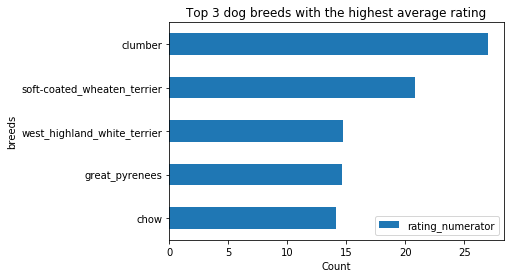

In [53]:
plt.figure(figsize=[8,16])
df_rating[4::-1].plot.barh()
plt.title("Top 3 dog breeds with the highest average rating")
plt.ylabel("breeds")
plt.xlabel("Count")

##### Result: Top 3 dog breeds with the highest average rating
- Top 1: clumber
- Top 2: soft-coated_wheaten_terrier
- Top 3: west_highland_white_terrier

#### 2. Top 3 dog breeds with the most tweets

In [54]:
df_twitter['dog_breed'].value_counts()[4::-1]

pug                    62
chihuahua              91
pembroke               95
labrador_retriever    108
golden_retriever      158
Name: dog_breed, dtype: int64

Text(0.5,0,'Count')

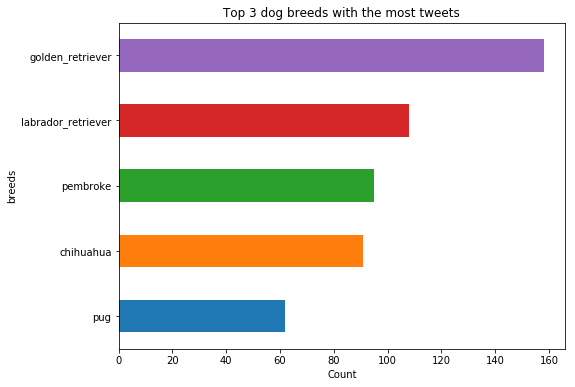

In [55]:
plt.figure(figsize=[8,6])
df_twitter['dog_breed'].value_counts()[4::-1].plot.barh()
plt.title("Top 3 dog breeds with the most tweets")
plt.ylabel("breeds")
plt.xlabel("Count")

##### Result: Top 3 dog breeds with the most tweets
- Top 1: golden_retriever
- Top 2: labrador_retriever
- Top 3: pembroke

#### 3. Top 3 dog breeds with  highest average favorite

In [66]:
df_favorite = df_twitter.groupby('dog_breed')[['favorite_count']].mean().sort_values('favorite_count', ascending=False).head(5)

In [67]:
df_favorite

,favorite_count
dog_breed,
saluki,24060.000000
bedlington_terrier,21153.166667
french_bulldog,18416.806452
bouvier_des_flandres,18032.000000
afghan_hound,17326.666667


Text(0.5,0,'Count')

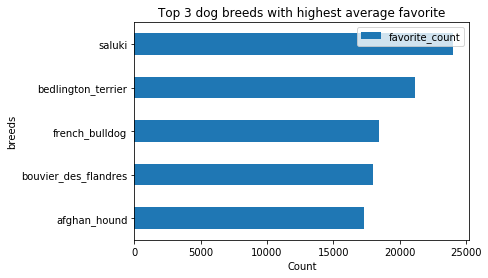

In [68]:
plt.figure(figsize=[8,16])
df_favorite[4::-1].plot.barh()
plt.title("Top 3 dog breeds with highest average favorite")
plt.ylabel("breeds")
plt.xlabel("Count")

##### Result:  Top 3 dog breeds with highest average favorite
- Top 1: saluki
- Top 2: bedlington_terrier
- Top 3: french_bulldog